In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np
import json
from datetime import datetime
import ast  # For safely evaluating string representations of dictionaries

# Load the GML file
file_path = 'county_graph_with_ntl.gml'
G = nx.read_gml(file_path)

def normalize_weights(graph, date_str):
    # Calculate the average ntl_sum for each edge
    for u, v in graph.edges():
        ntl_u = json.loads(graph.nodes[u]['ntl'])
        ntl_v = json.loads(graph.nodes[v]['ntl'])
        
        # Calculate the average ntl_sum for the two nodes
        avg_ntl_sum = (ntl_u[date_str][f'{date_str}_avg'] + ntl_v[date_str][f'{date_str}_avg']) / 2
        
        # Assign the average ntl_sum as the weight of the edge
        graph[u][v]['weight'] = avg_ntl_sum
    
    # Normalize the weights between 0 and 1
    weights = [graph[u][v]['weight'] for u, v in graph.edges()]
    min_weight = min(weights)
    max_weight = max(weights)
    
    for u, v in graph.edges():
        graph[u][v]['weight'] = 1 - ((graph[u][v]['weight'] - min_weight) / (max_weight - min_weight))

# Apply the function to the graph with a specific date
normalize_weights(G, '2024-09-25')

# Extract NTL Data for Specific Dates (2024-09-25 and 2024-09-30)
target_dates = ['2024-09-25', '2024-09-30']
differences = {}
data_list = []

# Extract county geometries and NTL average values for the two dates
for node, data in G.nodes(data=True):
    geometry_wkt = data.get('geometry', None)
    ntl_data = data.get('ntl', None)  # Get NTL data (assumed to be a dictionary or string)
    
    # convert string dictionary to dictionary
    ntl_dict = ast.literal_eval(ntl_data)
    
    # print(type(ntl_dict))

    if geometry_wkt and ntl_data:
        try:
            # Parse the geometry
            geometry = wkt.loads(geometry_wkt)
            
            # Parse NTL data and calculate the difference
            ntl_dict = ast.literal_eval(ntl_data)  # Safely evaluate string dictionary
            before = ntl_dict.get(target_dates[0], {}).get(f"{target_dates[0]}_avg", 0)
            after = ntl_dict.get(target_dates[1], {}).get(f"{target_dates[1]}_avg", 0)
            difference = after - before
            
            differences[node] = difference
            # Append data to list
            data_list.append({"geometry": geometry, "difference": difference})
        except Exception as e:
            print(f"Error processing node {node}: {e}")
    
print(differences)

{'Georgia_Appling': -2.0209722222222224, 'Georgia_Atkinson': -2.113469156762875, 'Georgia_Bacon': -1.9005372440830548, 'Georgia_Baker': -0.7858585858585859, 'Georgia_Baldwin': -0.06000664893617014, 'Georgia_Banks': 0.3294014084507051, 'Georgia_Barrow': 2.773012778860732, 'Georgia_Bartow': 0.3384768541562977, 'Georgia_Ben Hill': -1.3791802435259823, 'Georgia_Berrien': -2.3373900018723086, 'Georgia_Bibb': -9.371371083644725, 'Georgia_Bleckley': 0.11131276467029672, 'Georgia_Brantley': -0.573694029850746, 'Georgia_Brooks': -2.184774143302181, 'Georgia_Bryan': -0.708467532467532, 'Georgia_Bulloch': -0.8098603590766595, 'Georgia_Burke': -0.5399385560675887, 'Georgia_Butts': 2.3048582995951428, 'Georgia_Calhoun': -1.4339622641509435, 'Georgia_Camden': 0.7613812544045109, 'Georgia_Candler': -2.4732050841635176, 'Georgia_Carroll': 1.13424059139785, 'Georgia_Catoosa': 0.15056360708534555, 'Georgia_Charlton': -0.6857040229885056, 'Georgia_Chatham': -1.1157308694622117, 'Georgia_Chattahoochee': -

<Figure size 1000x1000 with 0 Axes>

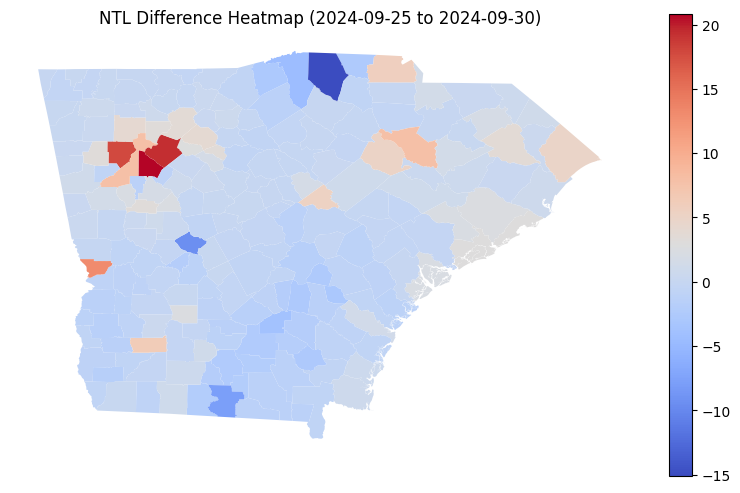

In [3]:
import geopandas as gpd

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(data_list)

# Plot the heatmap
plt.figure(figsize=(10, 10))
gdf.plot(column='difference', cmap='coolwarm', legend=True, figsize=(10, 6))
plt.title('NTL Difference Heatmap (2024-09-25 to 2024-09-30)')
plt.axis('off')
plt.show()

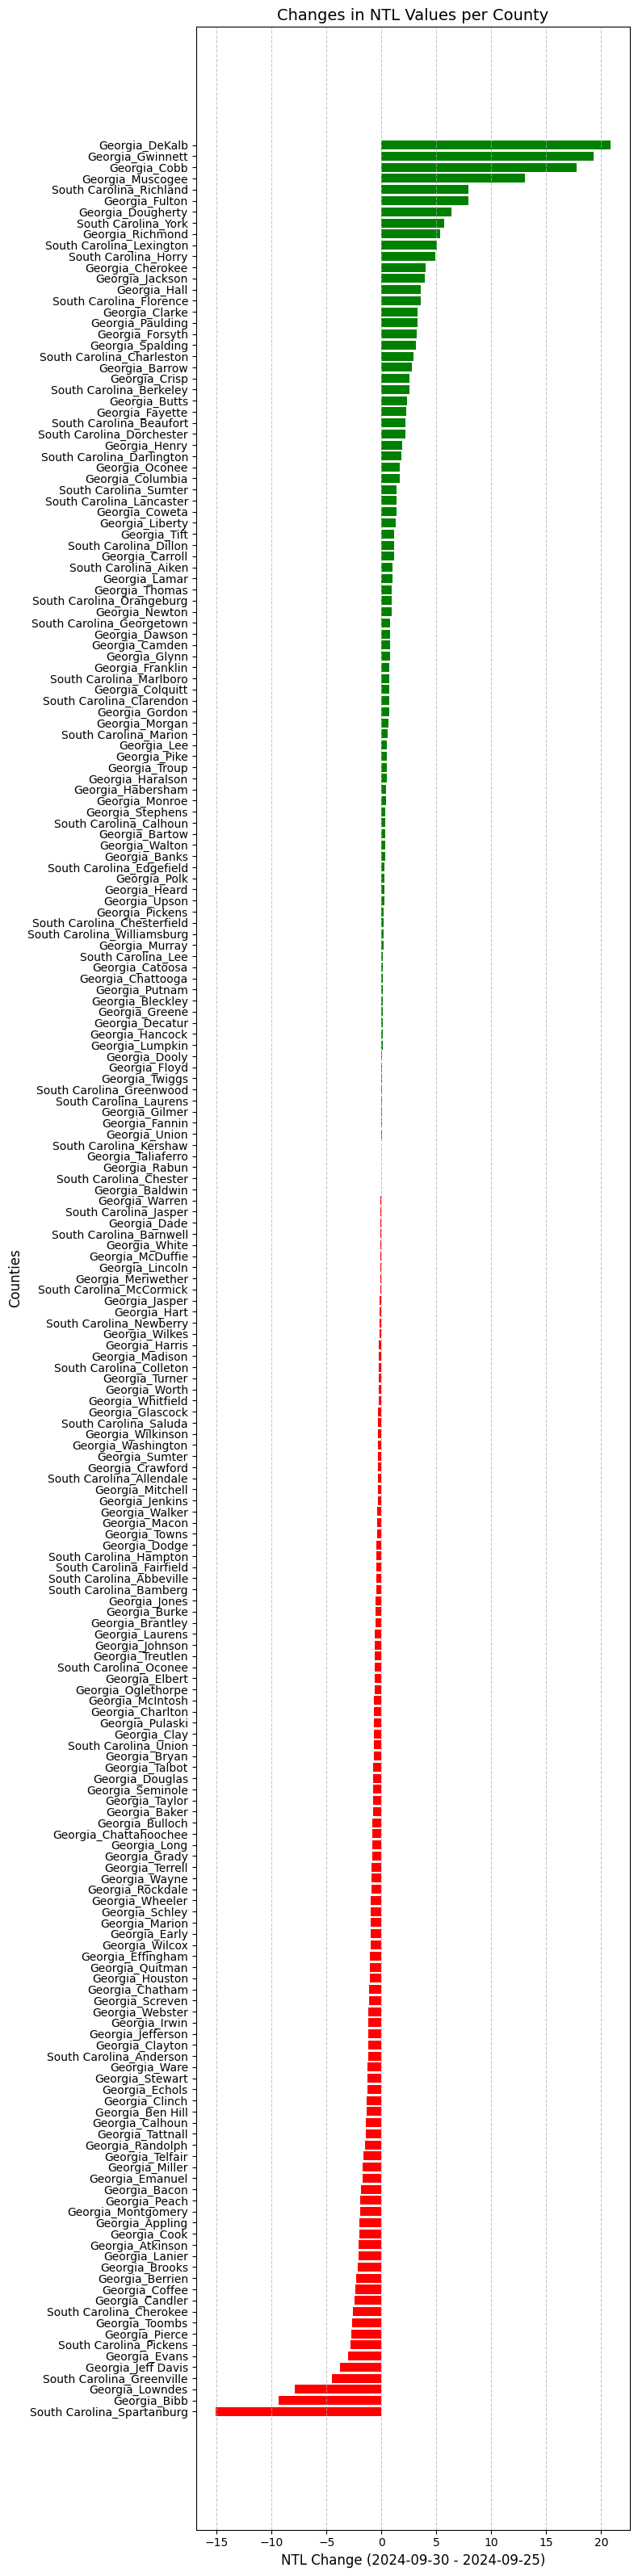

In [6]:
# Sort counties by the difference for better visualization
sorted_differences = dict(sorted(differences.items(), key=lambda item: item[1]))
                                                    
# Extract counties and differences
counties = list(sorted_differences.keys())
changes = list(sorted_differences.values())

# Create a horizontal bar chart
plt.figure(figsize=(8, 32))
colors = ['red' if change < 0 else 'green' for change in changes]
plt.barh(counties, changes, color=colors)

# Add labels and title
plt.xlabel('NTL Change (2024-09-30 - 2024-09-25)', fontsize=12)
plt.ylabel('Counties', fontsize=12)
plt.title('Changes in NTL Values per County', fontsize=14)

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout to fit labels
plt.tight_layout()

# Show the plot
plt.show()


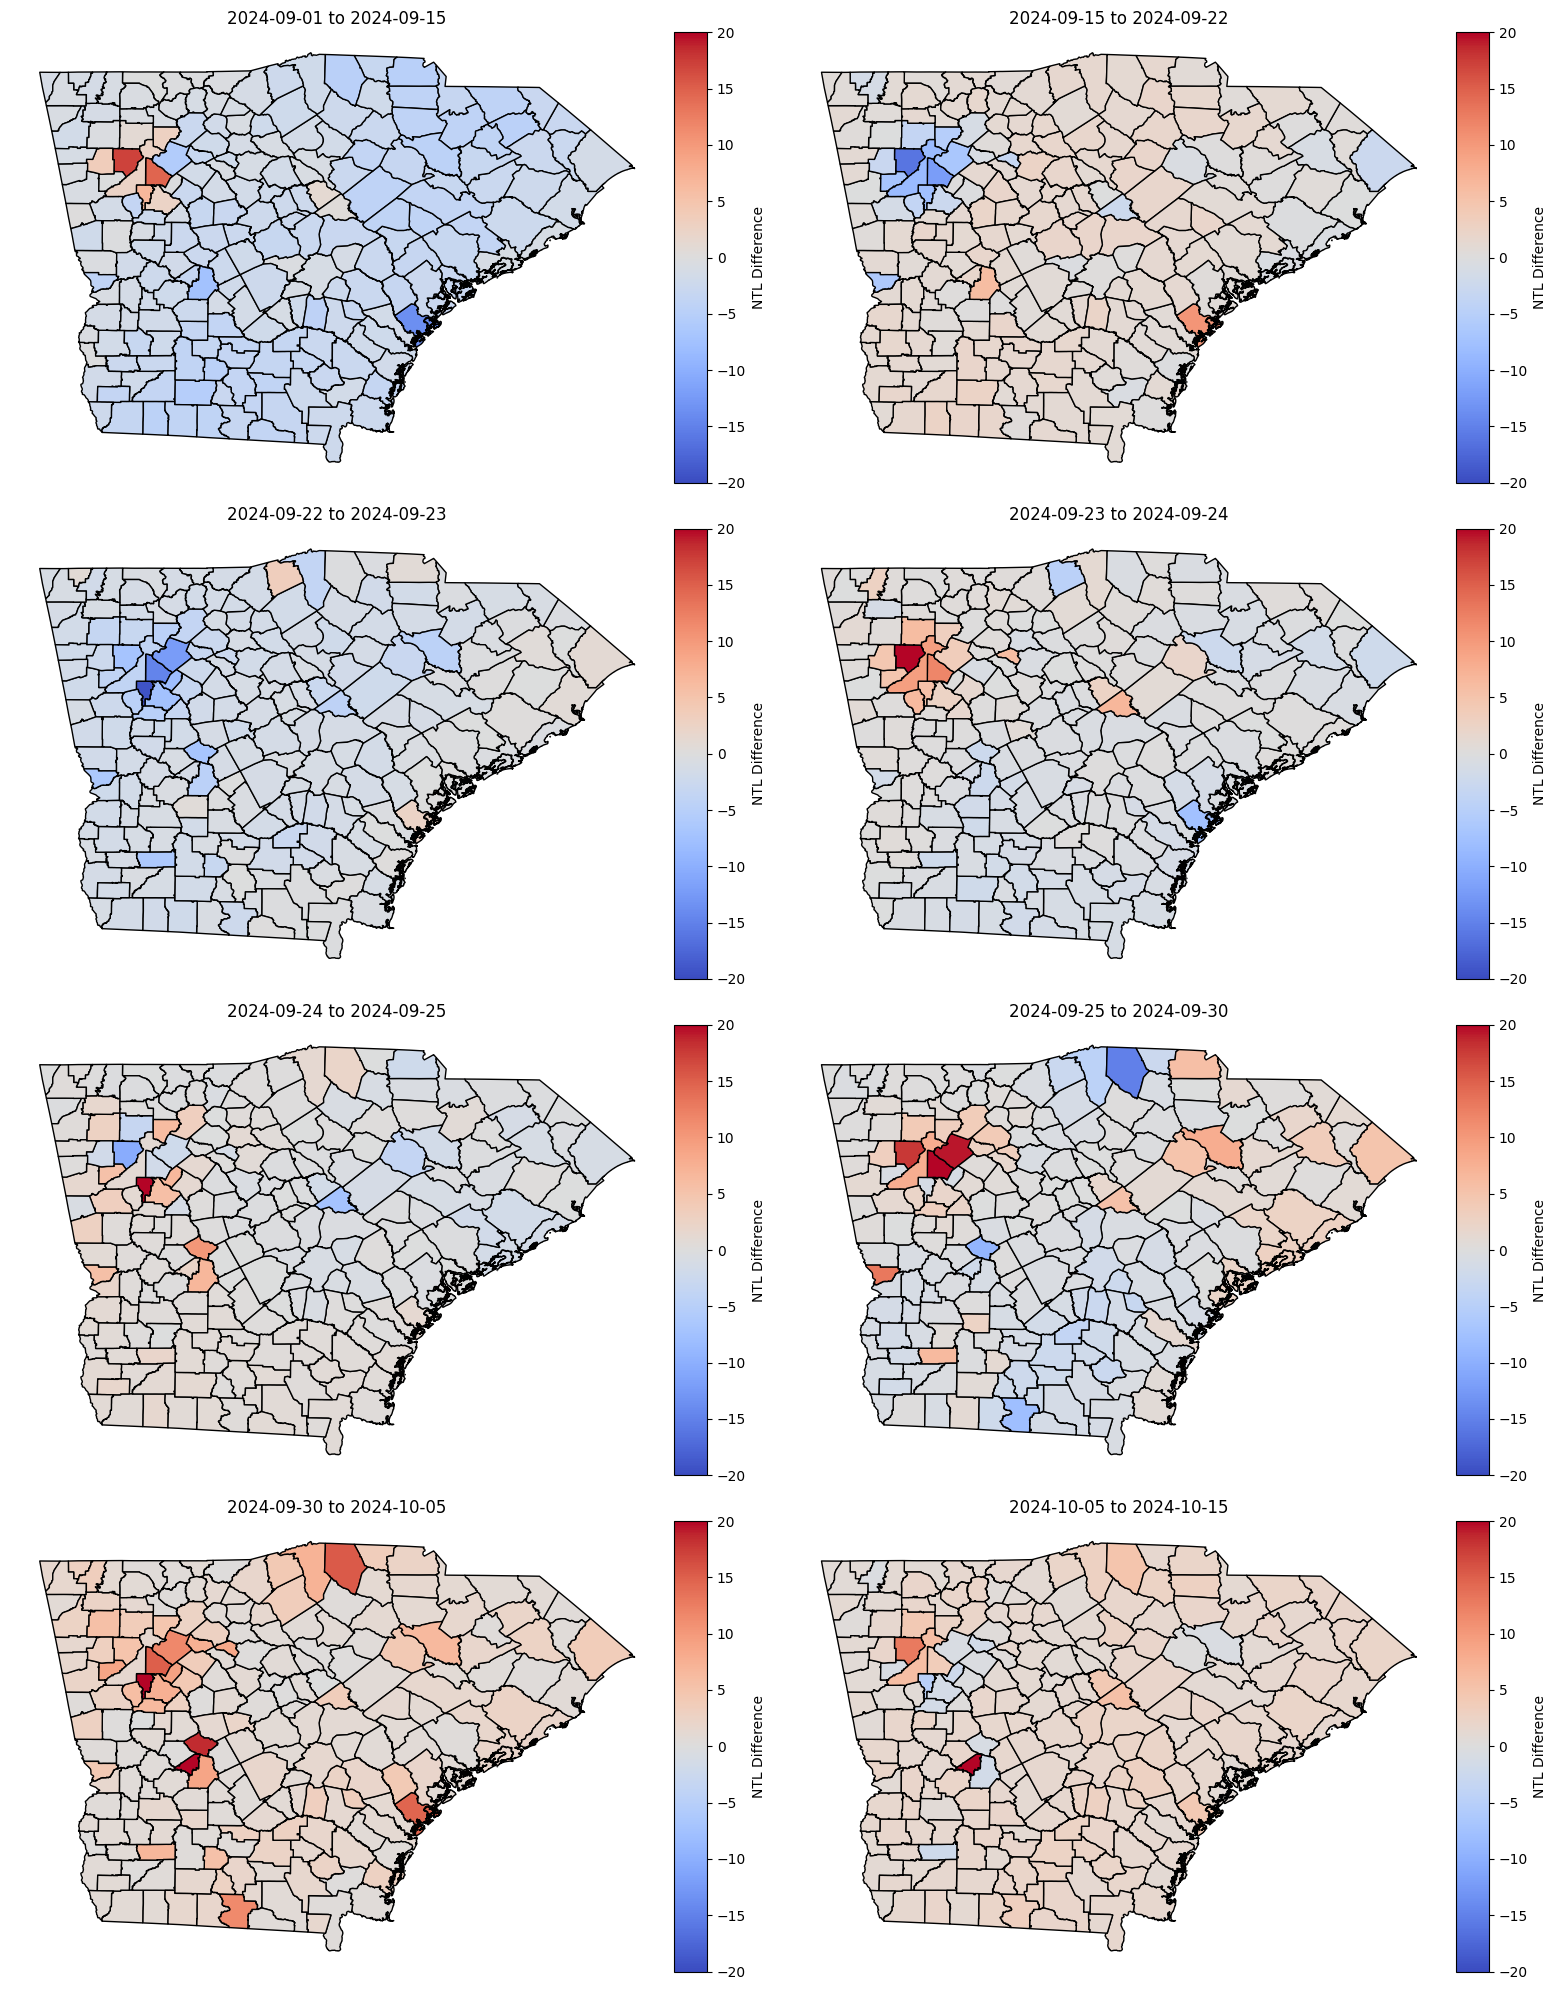

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
import ast  # For safely evaluating string representations of dictionaries
import numpy as np
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the GML file
file_path = 'county_graph_with_ntl.gml'
G = nx.read_gml(file_path)

# Define dates
dates = [
    '2024-09-01', '2024-09-15', '2024-09-22', '2024-09-23',
    '2024-09-24', '2024-09-25', '2024-09-30', '2024-10-05', '2024-10-15'
]
heatmaps = []
all_differences = []

# Calculate differences and store min/max values
for i in range(1, len(dates)):  # Start from the second date
    current_date = dates[i]
    previous_date = dates[i - 1]
    
    differences = []
    for node, data in G.nodes(data=True):
        geometry_wkt = data.get('geometry', None)
        ntl_data = data.get('ntl', None)
        
        if geometry_wkt and ntl_data:
            try:
                # Parse geometry and NTL data
                geometry = wkt.loads(geometry_wkt)
                ntl_dict = ast.literal_eval(ntl_data)  # Safely evaluate string dictionary
                before = ntl_dict.get(previous_date, {}).get(f"{previous_date}_avg", 0)
                after = ntl_dict.get(current_date, {}).get(f"{current_date}_avg", 0)
                difference = after - before
                all_differences.append(difference)
                differences.append({"geometry": geometry, "difference": difference})
            except Exception as e:
                print(f"Error processing node {node}: {e}")
    
    # Create GeoDataFrame for the current difference
    gdf = gpd.GeoDataFrame(differences)
    heatmaps.append((f"{previous_date} to {current_date}", gdf))

# Determine global min and max for uniform legend
norm = Normalize(vmin=-20, vmax=20)

# Plot all heatmaps with uniform legend
fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # 4 rows, 2 columns

for ax, (title, gdf) in zip(axes.flatten(), heatmaps):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # Add colorbar

    gdf.plot(
        column='difference',
        cmap='coolwarm',
        norm=norm,
        legend=True,
        ax=ax,
        cax=cax,
        edgecolor='black',
        legend_kwds={'label': "NTL Difference", 'orientation': "vertical"}
    )
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# (done) correlation between changes --> tun benachbarte counties in ähnliche richtung sich verändern, 
#  => sind counties mit wenig strom in nähe von counties mit wenig strom (am ende in analysis.ipynb)

# (done) degree distribution --> an wie viele andere grenzen die counties, ... 
# correlation between area und degree von neighbors: average degree vs size plotten und anschauen
# => sanity check (wie ist netzwerk grundsätzlich aufgebaut) (analysis.ipynb -> 2 plots + communities?)

# (done) vergleichen mit vorjahr wegen seasonal changes ==> gleicher tag zu vorjahr --> sieht man einfluss von hurricane

# (done?) is difference correlated with area?  => no

# (done) heatmaps plotten mit avg values per tag und schauen wie es sich verändert --> mit vorjahr vergleichen

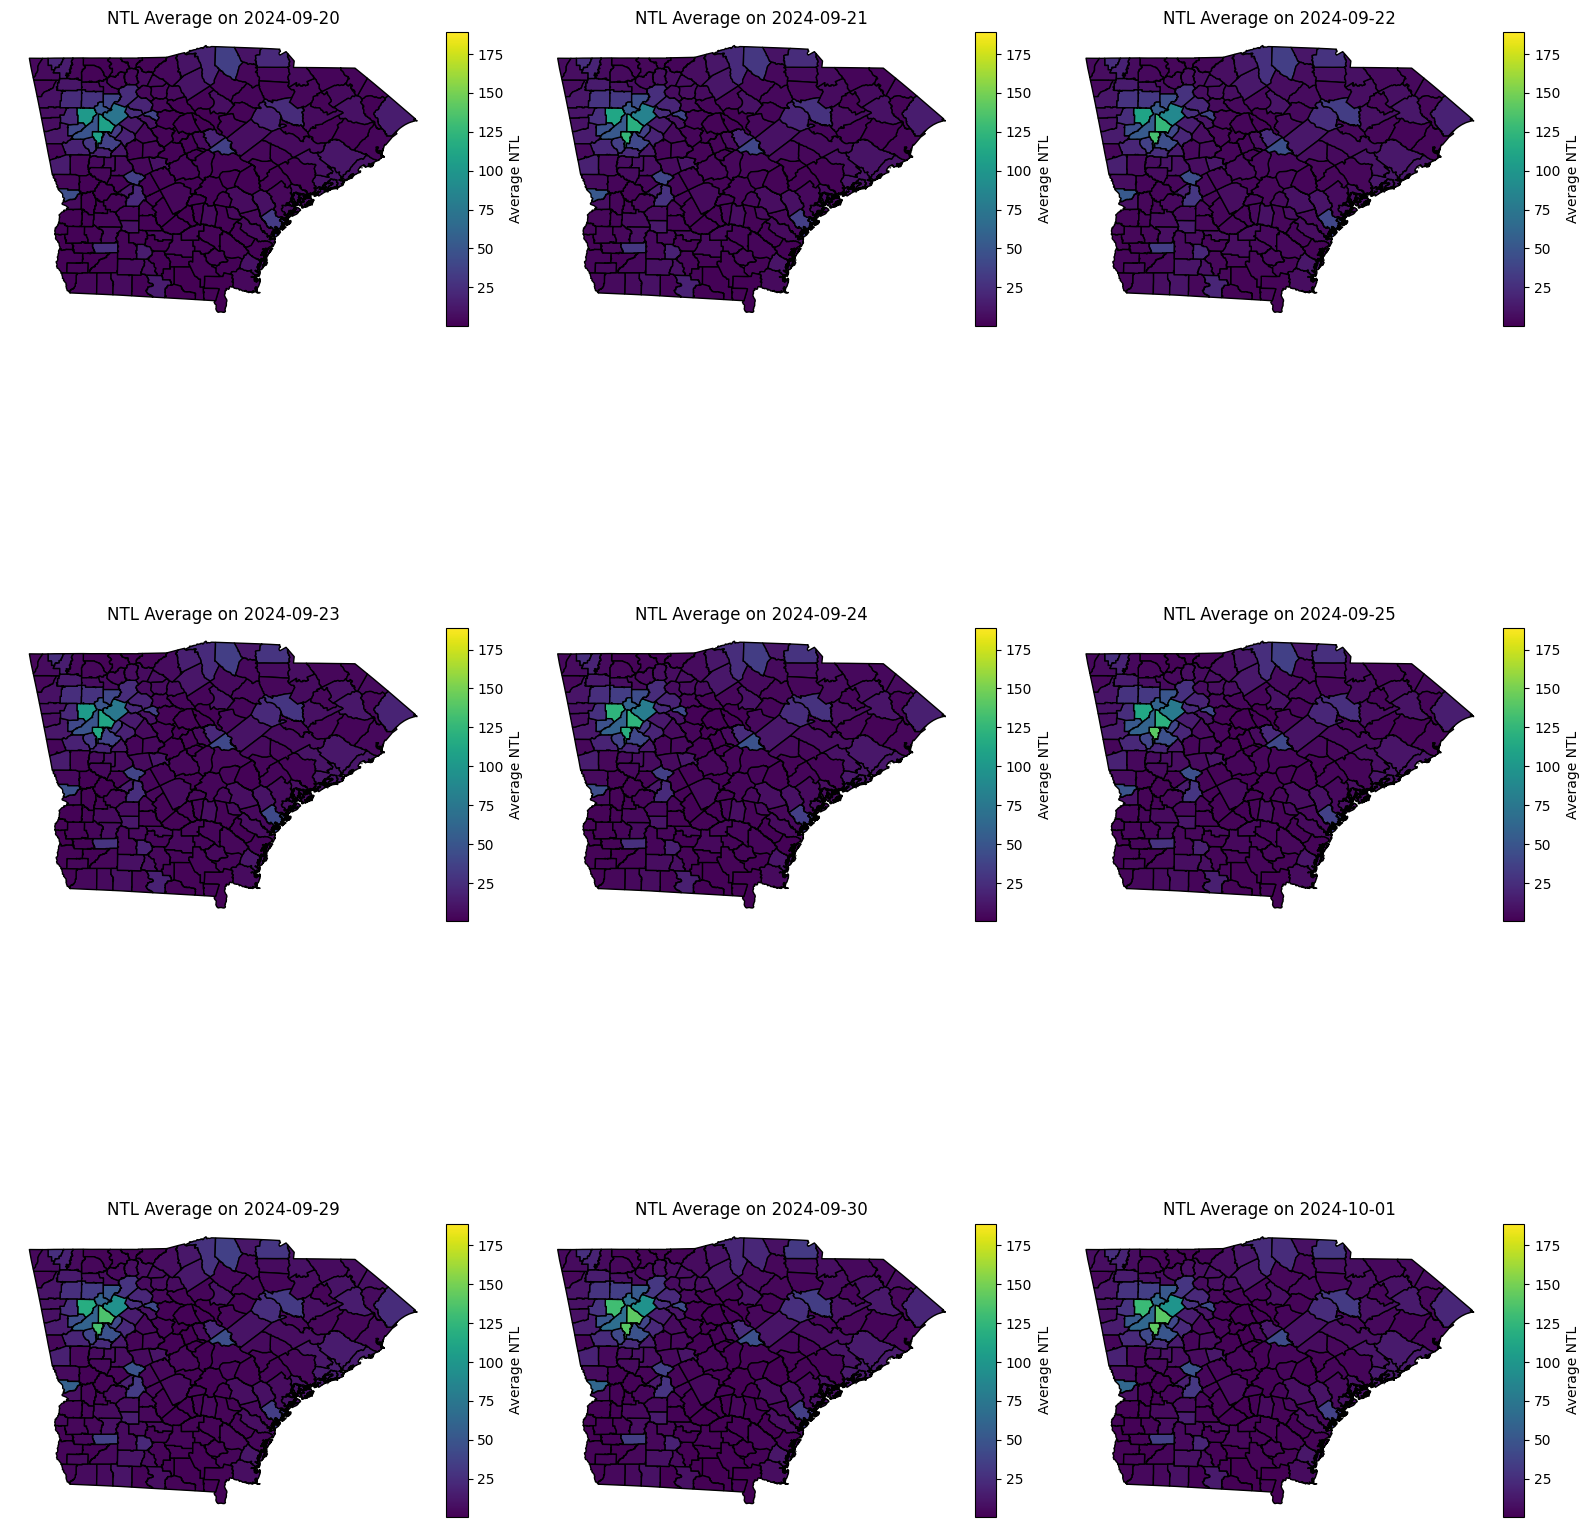

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
import ast  # For safely evaluating string representations of dictionaries
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the GML file
file_path = 'county_graph_with_ntl.gml'
G = nx.read_gml(file_path)

# Define dates
dates = [
    '2024-09-20', '2024-09-21', '2024-09-22', '2024-09-23',
    '2024-09-24', '2024-09-25','2024-09-29', '2024-09-30', 
    '2024-10-01','2024-10-02','2024-10-03'
]
heatmaps = []

# Compute and store average NTL values for each day
for date in dates:
    averages = []
    for node, data in G.nodes(data=True):
        geometry_wkt = data.get('geometry', None)
        ntl_data = data.get('ntl', None)
        
        if geometry_wkt and ntl_data:
            try:
                # Parse geometry and NTL data
                geometry = wkt.loads(geometry_wkt)
                ntl_dict = ast.literal_eval(ntl_data)  # Safely evaluate string dictionary
                avg_value = ntl_dict.get(date, {}).get(f"{date}_avg", None)
                
                if avg_value is not None:
                    averages.append({"geometry": geometry, "average": avg_value})
            except Exception as e:
                print(f"Error processing node {node}: {e}")
    
    # Create GeoDataFrame for the current date
    gdf = gpd.GeoDataFrame(averages)
    heatmaps.append((date, gdf))

# Determine global min and max for uniform legend across all heatmaps
all_avg_values = [entry["average"] for _, gdf in heatmaps for entry in gdf.to_dict("records")]
vmin, vmax = min(all_avg_values), max(all_avg_values)
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot all heatmaps with uniform legend
fig, axes = plt.subplots(3, 3, figsize=(16, 20))  # Adjust layout: 3 rows, 3 columns

for ax, (title, gdf) in zip(axes.flatten(), heatmaps):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # Add colorbar

    gdf.plot(
        column='average',
        cmap='viridis',
        norm=norm,
        legend=True,
        ax=ax,
        cax=cax,
        edgecolor='black',
        legend_kwds={'label': "Average NTL", 'orientation': "vertical"}
    )
    ax.set_title(f"NTL Average on {title}")
    ax.axis('off')

# Remove unused subplots
for ax in axes.flatten()[len(heatmaps):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


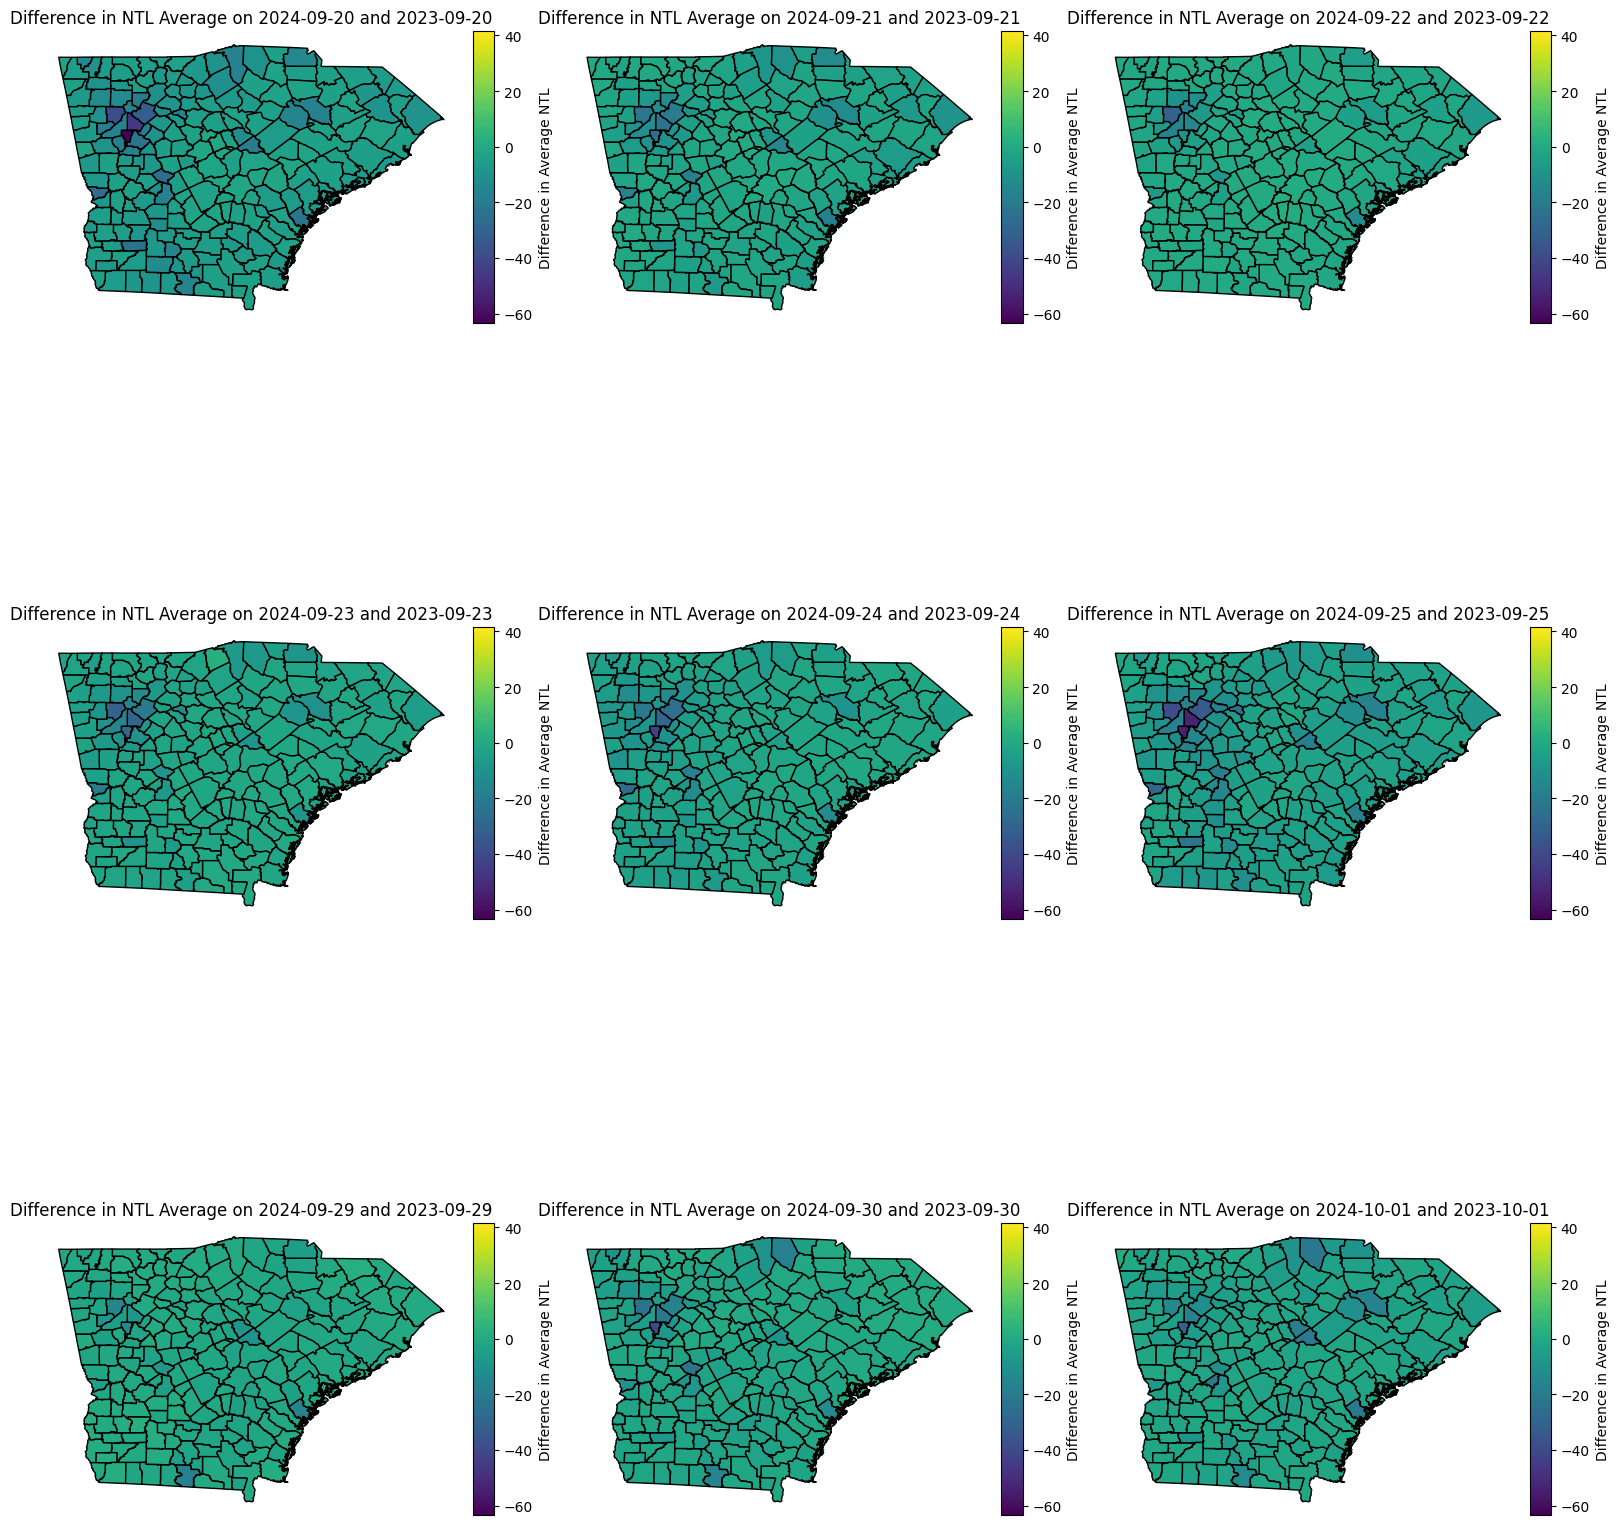

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
import ast  # For safely evaluating string representations of dictionaries
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the GML file
file_path = 'county_graph_with_ntl.gml'
G = nx.read_gml(file_path)

# Define dates
dates = [
    '2024-09-20', '2024-09-21', '2024-09-22', '2024-09-23',
    '2024-09-24', '2024-09-25','2024-09-29', '2024-09-30', 
    '2024-10-01','2024-10-02','2024-10-03'
]
heatmaps = []

# Compute and store average NTL values for each day
for date in dates:
    averages = []
    for node, data in G.nodes(data=True):
        geometry_wkt = data.get('geometry', None)
        ntl_data = data.get('ntl', None)
        
        if geometry_wkt and ntl_data:
            try:
                # Parse geometry and NTL data
                geometry = wkt.loads(geometry_wkt)
                ntl_dict = ast.literal_eval(ntl_data)  # Safely evaluate string dictionary
                date_old = date.replace("2024","2023")
                avg_value = (ntl_dict.get(date, {}).get(f"{date}_avg", None))-(ntl_dict.get(date_old, {}).get(f"{date_old}_avg", None))
                
                if avg_value is not None:
                    averages.append({"geometry": geometry, "average": avg_value})
            except Exception as e:
                print(f"Error processing node {node}: {e}")
    
    # Create GeoDataFrame for the current date
    gdf = gpd.GeoDataFrame(averages)
    heatmaps.append((date, gdf))

# Determine global min and max for uniform legend across all heatmaps
all_avg_values = [entry["average"] for _, gdf in heatmaps for entry in gdf.to_dict("records")]
vmin, vmax = min(all_avg_values), max(all_avg_values)
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot all heatmaps with uniform legend
fig, axes = plt.subplots(3, 3, figsize=(16, 20))  # Adjust layout: 3 rows, 3 columns

for ax, (title, gdf) in zip(axes.flatten(), heatmaps):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # Add colorbar

    gdf.plot(
        column='average',
        cmap='viridis',
        norm=norm,
        legend=True,
        ax=ax,
        cax=cax,
        edgecolor='black',
        legend_kwds={'label': "Difference in Average NTL", 'orientation': "vertical"}
    )
    ax.set_title(f'Difference in NTL Average on {title} and {title.replace("2024","2023")}')
    ax.axis('off')

# Remove unused subplots
for ax in axes.flatten()[len(heatmaps):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


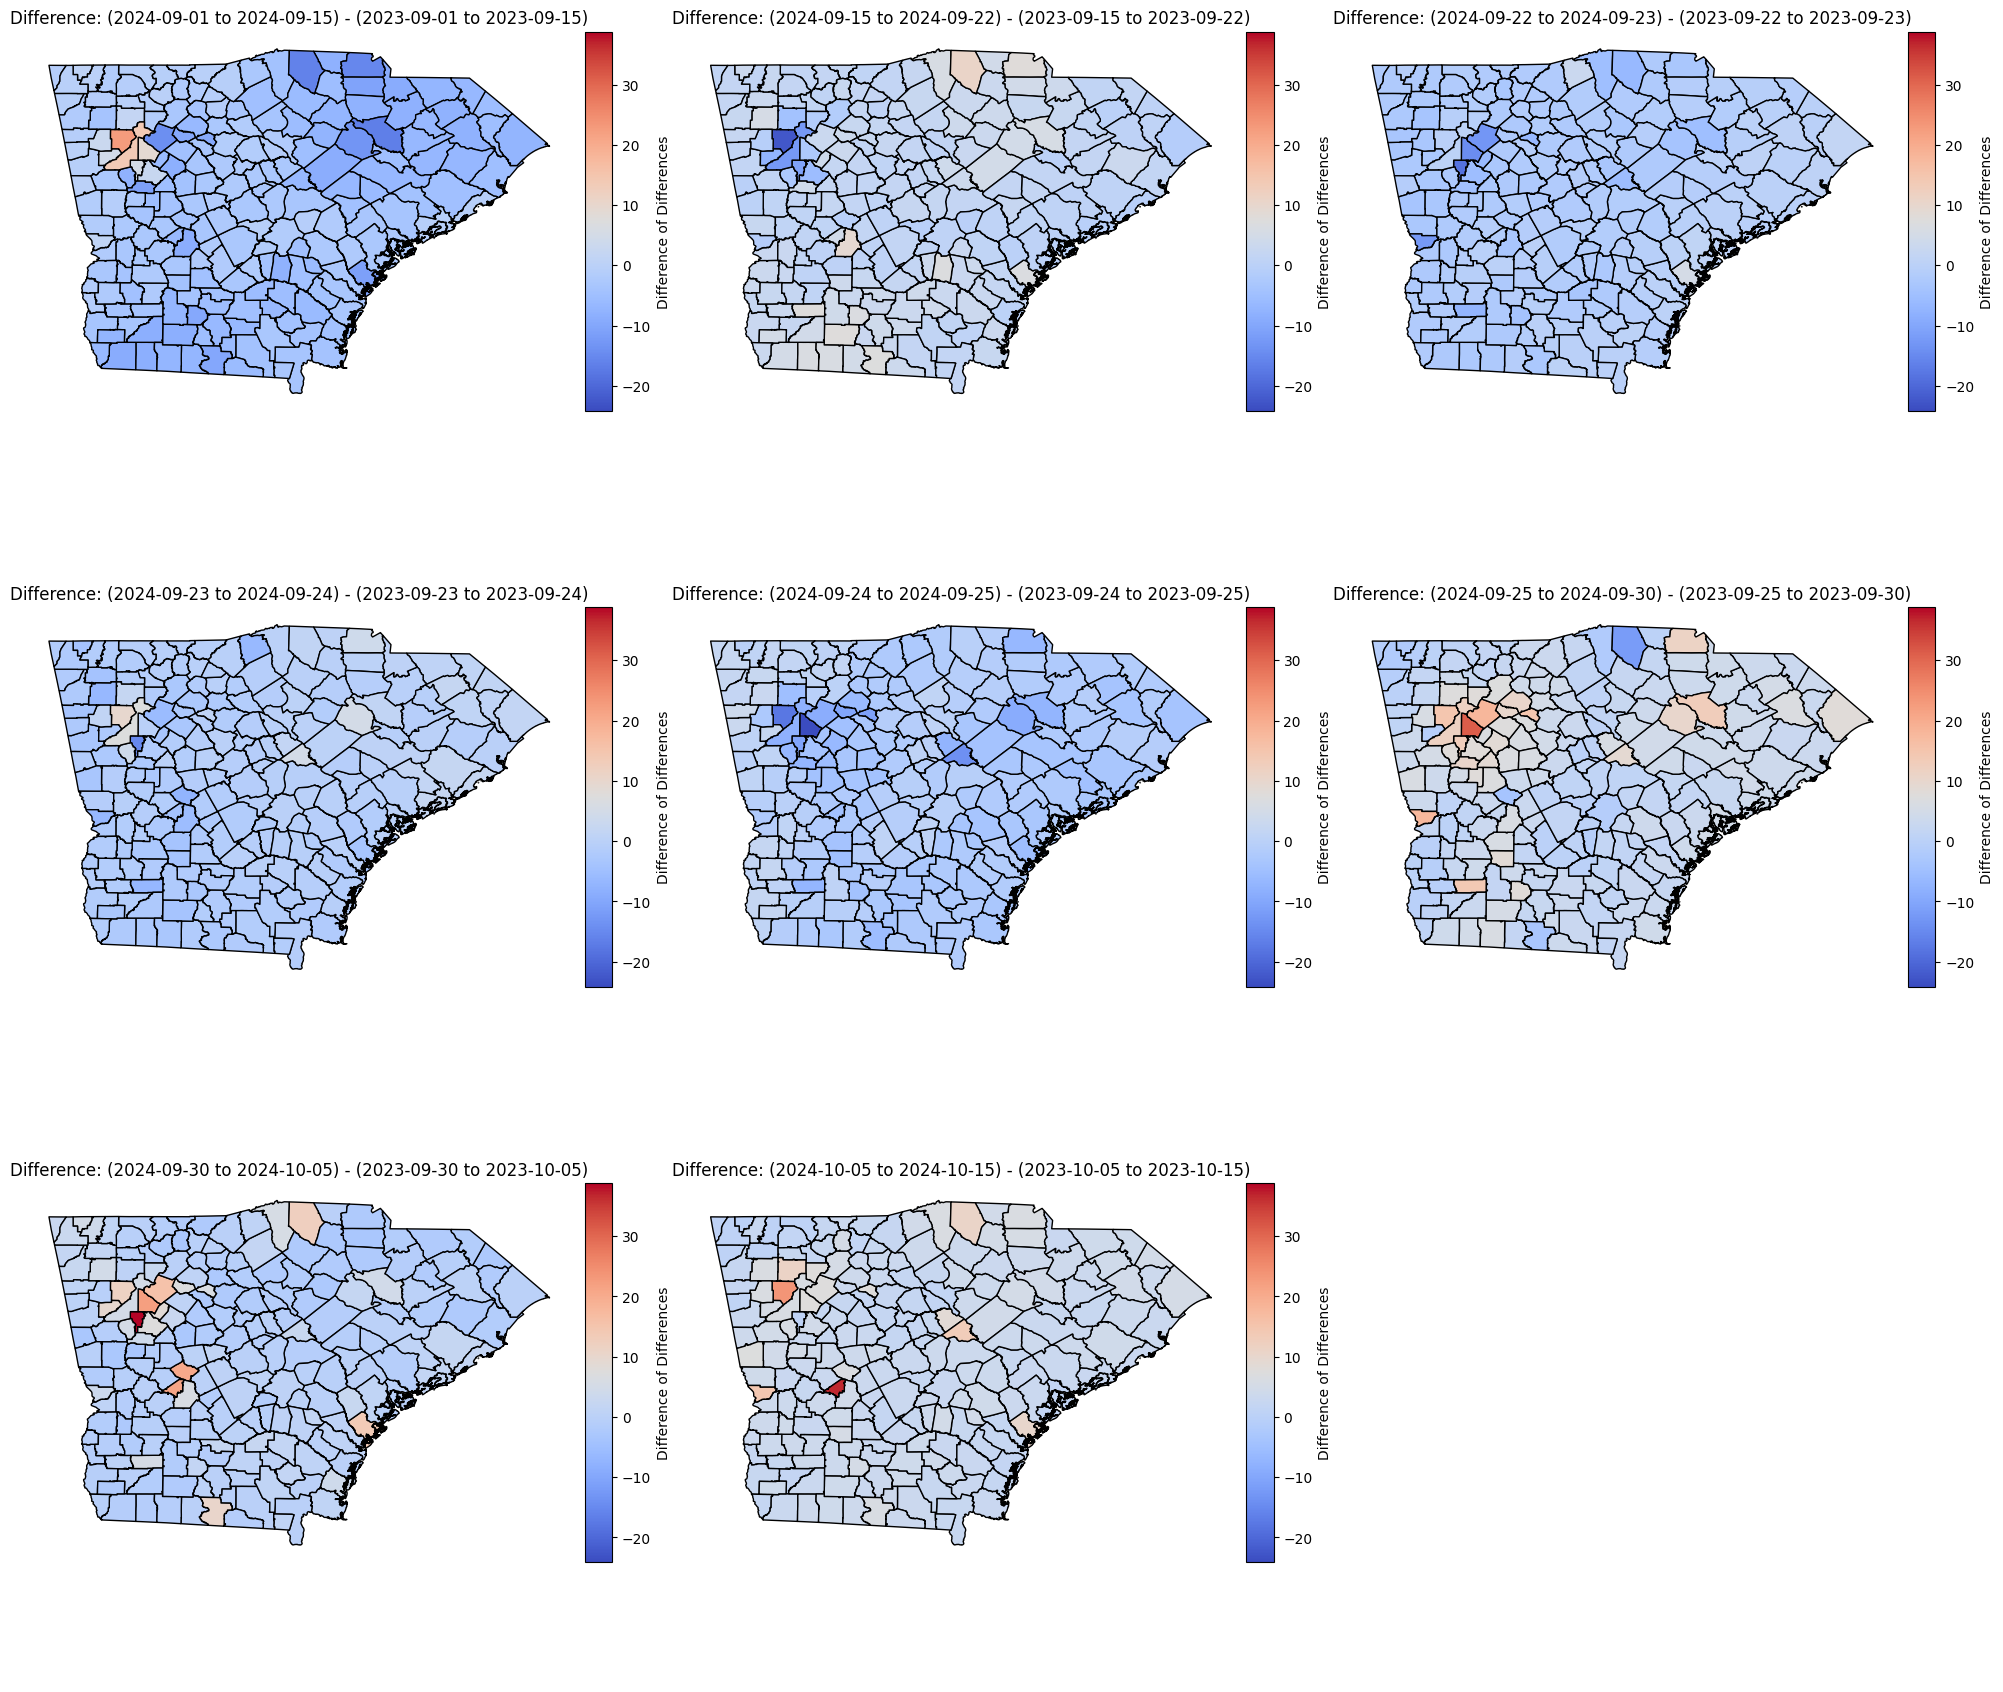

In [25]:
import math
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
import ast  # For safely evaluating string representations of dictionaries
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the GML file
file_path = 'county_graph_with_ntl.gml'
G = nx.read_gml(file_path)

# Define 2023 and 2024 dates
dates_2024 = [
    '2024-09-01', '2024-09-15', '2024-09-22', '2024-09-23',
    '2024-09-24', '2024-09-25', '2024-09-30', '2024-10-05', '2024-10-15'
]

dates_2023 = [date.replace('2024', '2023') for date in dates_2024]

# Create consecutive date pairs
pairs_2024 = [(dates_2024[i], dates_2024[i+1]) for i in range(len(dates_2024)-1)]
pairs_2023 = [(dates_2023[i], dates_2023[i+1]) for i in range(len(dates_2023)-1)]

heatmaps = []

# Compute "difference of differences" for each pair
for (prev_2023, curr_2023), (prev_2024, curr_2024) in zip(pairs_2023, pairs_2024):
    differences = []
    
    for node, data in G.nodes(data=True):
        geometry_wkt = data.get('geometry', None)
        ntl_data = data.get('ntl', None)
        
        if geometry_wkt and ntl_data:
            try:
                # Parse geometry and NTL data
                geometry = wkt.loads(geometry_wkt)
                ntl_dict = ast.literal_eval(ntl_data)  # Safely evaluate string dictionary

                # Compute 2023 and 2024 differences
                before_2023 = ntl_dict.get(prev_2023, {}).get(f"{prev_2023}_avg", 0)
                after_2023 = ntl_dict.get(curr_2023, {}).get(f"{curr_2023}_avg", 0)
                diff_2023 = after_2023 - before_2023

                before_2024 = ntl_dict.get(prev_2024, {}).get(f"{prev_2024}_avg", 0)
                after_2024 = ntl_dict.get(curr_2024, {}).get(f"{curr_2024}_avg", 0)
                diff_2024 = after_2024 - before_2024

                # Compute the difference of differences
                difference = diff_2024 - diff_2023
                differences.append({"geometry": geometry, "difference": difference})
            except Exception as e:
                print(f"Error processing node {node}: {e}")
    
    # Create GeoDataFrame for the current difference
    gdf = gpd.GeoDataFrame(differences)
    title = f"Difference: ({prev_2024} to {curr_2024}) - ({prev_2023} to {curr_2023})"
    heatmaps.append((title, gdf))

# Determine global min and max for uniform legend
all_differences = [entry["difference"] for _, gdf in heatmaps for entry in gdf.to_dict("records")]
vmin, vmax = min(all_differences), max(all_differences)
norm = Normalize(vmin=vmin, vmax=vmax)

# Dynamic layout: Calculate number of rows and columns
num_plots = len(heatmaps)
cols = 3  # Set a fixed number of columns
rows = math.ceil(num_plots / cols)

# Plot all heatmaps with uniform legend
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 6))  # Adjust height dynamically

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, (title, gdf) in zip(axes, heatmaps):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # Add colorbar

    gdf.plot(
        column='difference',
        cmap='coolwarm',
        norm=norm,
        legend=True,
        ax=ax,
        cax=cax,
        edgecolor='black',
        legend_kwds={'label': "Difference of Differences", 'orientation': "vertical"}
    )
    ax.set_title(title)
    ax.axis('off')

# Turn off unused axes
for ax in axes[len(heatmaps):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


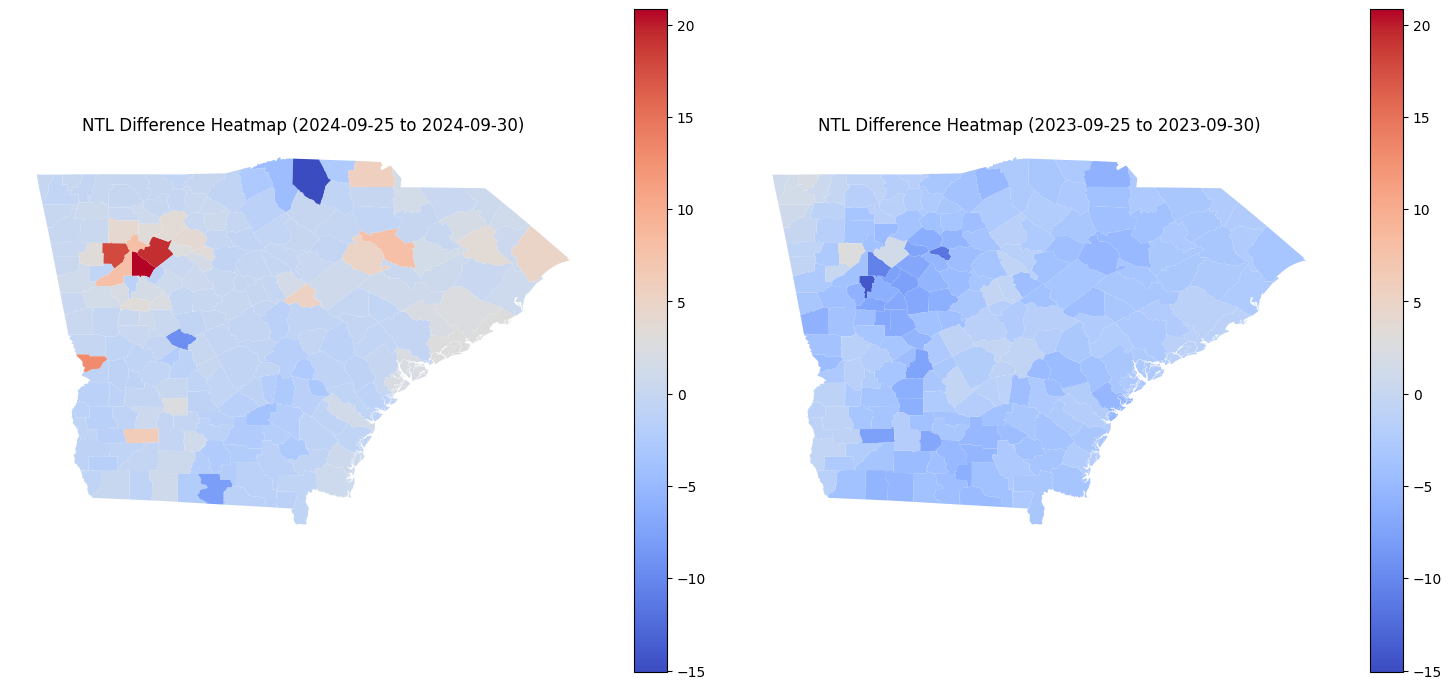

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import ast
from shapely import wkt

# Define target dates
target_dates_1 = ['2024-09-25', '2024-09-30']
target_dates_2 = ['2023-09-25', '2023-09-30']

# Function to extract NTL data and calculate the difference for a specific date range
def extract_ntl_difference(target_dates):
    differences = {}
    data_list = []
    
    # Extract county geometries and NTL average values for the two dates
    for node, data in G.nodes(data=True):
        geometry_wkt = data.get('geometry', None)
        ntl_data = data.get('ntl', None)  # Get NTL data (assumed to be a dictionary or string)

        # Convert string dictionary to dictionary
        ntl_dict = ast.literal_eval(ntl_data) if ntl_data else {}
        
        if geometry_wkt and ntl_data:
            try:
                # Parse the geometry
                geometry = wkt.loads(geometry_wkt)

                # Parse NTL data and calculate the difference
                before = ntl_dict.get(target_dates[0], {}).get(f"{target_dates[0]}_avg", 0)
                after = ntl_dict.get(target_dates[1], {}).get(f"{target_dates[1]}_avg", 0)
                difference = after - before

                differences[node] = difference
                # Append data to list
                data_list.append({"geometry": geometry, "difference": difference})
            except Exception as e:
                print(f"Error processing node {node}: {e}")
                
    return data_list

# Extract data for the two different date ranges
data_list_2024 = extract_ntl_difference(target_dates_1)
data_list_2023 = extract_ntl_difference(target_dates_2)

# Create GeoDataFrames for each date range
gdf_2024 = gpd.GeoDataFrame(data_list_2024)
gdf_2023 = gpd.GeoDataFrame(data_list_2023)

# Get the common color scale limits (vmin, vmax) from both data sets
min_value = min(gdf_2024['difference'].min(), gdf_2023['difference'].min())
max_value = max(gdf_2024['difference'].max(), gdf_2023['difference'].max())

# Plotting both maps side by side with the same axis scale
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

# Plot the first heatmap (NTL Difference Heatmap for 2024)
gdf_2024.plot(column='difference', cmap='coolwarm', legend=True, ax=axes[0], vmin=min_value, vmax=max_value)
axes[0].set_title('NTL Difference Heatmap (2024-09-25 to 2024-09-30)')
axes[0].axis('off')  # Turn off axis for this plot

# Plot the second heatmap (NTL Difference Heatmap for 2023)
gdf_2023.plot(column='difference', cmap='coolwarm', legend=True, ax=axes[1], vmin=min_value, vmax=max_value)
axes[1].set_title('NTL Difference Heatmap (2023-09-25 to 2023-09-30)')
axes[1].axis('off')  # Turn off axis for this plot

# Ensure the same axis scale for both plots
for ax in axes:
    ax.set_aspect('equal', 'box')  # Ensures both plots have the same aspect ratio

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


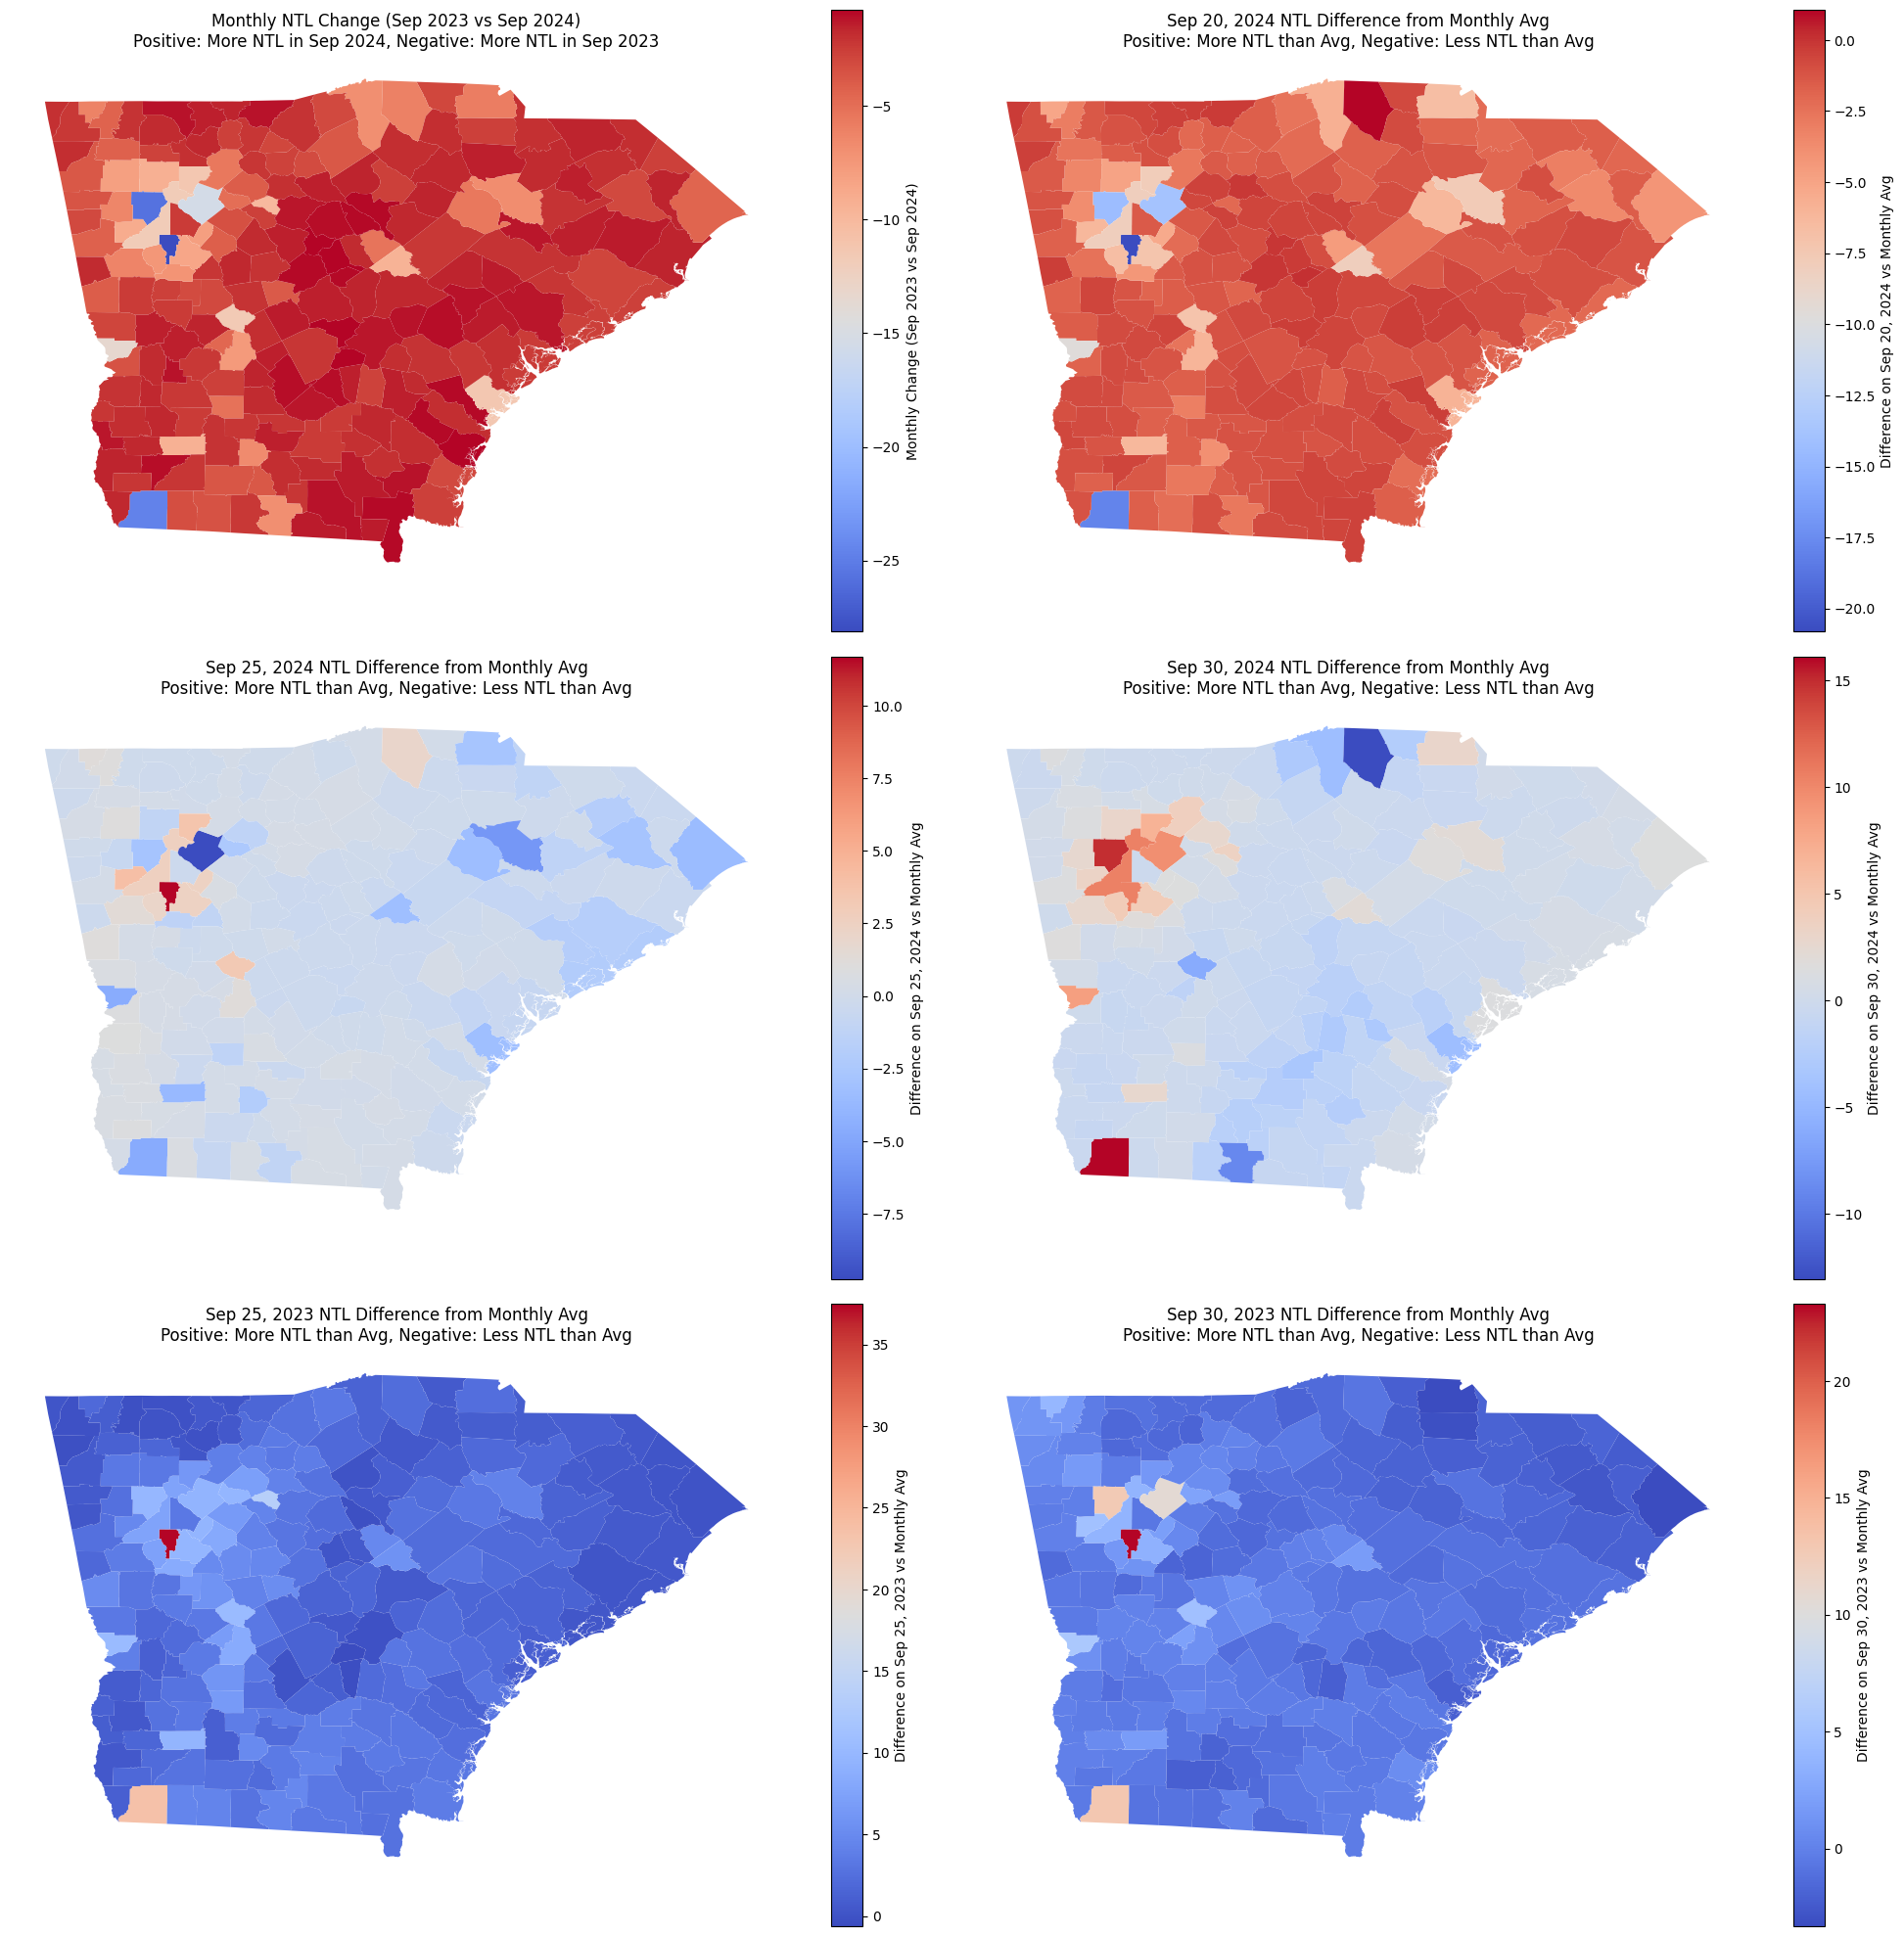

In [13]:
import pandas as pd
import ast
from shapely import wkt
import matplotlib.pyplot as plt
import geopandas as gpd

# Extract NTL data into a DataFrame
ntl_data = []
for node, data in G.nodes(data=True):
    ntl_dict = ast.literal_eval(data.get('ntl', '{}'))
    for date, values in ntl_dict.items():
        ntl_data.append({
            'county': node,
            'date': pd.to_datetime(date),
            'ntl_avg': values.get(f"{date}_avg", 0),
            'geometry': data.get('geometry', None)
        })

# Convert to DataFrame
ntl_df = pd.DataFrame(ntl_data)

# Convert geometry column to WKT objects
ntl_df['geometry'] = ntl_df['geometry'].apply(lambda g: wkt.loads(g) if g else None)

# Filter for September 2023 and September 2024
sep_2023 = ntl_df[(ntl_df['date'] >= '2023-09-01') & (ntl_df['date'] <= '2023-09-30')]
sep_2024 = ntl_df[(ntl_df['date'] >= '2024-09-01') & (ntl_df['date'] <= '2024-09-30')]

# Calculate monthly averages
sep_2023_avg = sep_2023.groupby('county')['ntl_avg'].mean().reset_index(name='sep_2023_avg')
sep_2024_avg = sep_2024.groupby('county')['ntl_avg'].mean().reset_index(name='sep_2024_avg')

# Merge and calculate difference
comparison_df = pd.merge(sep_2023_avg, sep_2024_avg, on='county')
comparison_df['monthly_diff'] = comparison_df['sep_2024_avg'] - comparison_df['sep_2023_avg']

# Calculate differences for specific dates in September 2024
for specific_date in ['2024-09-20', '2024-09-25', '2024-09-30']:
    specific_date_df = ntl_df[ntl_df['date'] == specific_date][['county', 'ntl_avg']]
    specific_date_df = specific_date_df.rename(columns={'ntl_avg': f'{specific_date}_ntl'})
    comparison_df = pd.merge(comparison_df, specific_date_df, on='county', how='left')
    comparison_df[f'{specific_date}_diff'] = comparison_df[f'{specific_date}_ntl'] - comparison_df['sep_2024_avg']

# Calculate differences for specific dates in September 2023
for specific_date in ['2023-09-25', '2023-09-30']:
    specific_date_df = ntl_df[ntl_df['date'] == specific_date][['county', 'ntl_avg']]
    specific_date_df = specific_date_df.rename(columns={'ntl_avg': f'{specific_date}_ntl'})
    comparison_df = pd.merge(comparison_df, specific_date_df, on='county', how='left')
    comparison_df[f'{specific_date}_diff'] = comparison_df[f'{specific_date}_ntl'] - comparison_df['sep_2023_avg']

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    comparison_df, geometry=[wkt.loads(data['geometry']) for _, data in G.nodes(data=True) if data.get('geometry')]
)

# Plot monthly differences
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

# Plot: Monthly change (2023 vs 2024)
gdf.plot(column='monthly_diff', ax=ax[0, 0], cmap='coolwarm', legend=True, 
         legend_kwds={'label': "Monthly Change (Sep 2023 vs Sep 2024)"})
ax[0, 0].set_title("Monthly NTL Change (Sep 2023 vs Sep 2024)\nPositive: More NTL in Sep 2024, Negative: More NTL in Sep 2023")
ax[0, 0].axis('off')

# Plot: Sep 20, 2024 difference from average
gdf.plot(column='2024-09-20_diff', ax=ax[0, 1], cmap='coolwarm', legend=True, 
         legend_kwds={'label': "Difference on Sep 20, 2024 vs Monthly Avg"})
ax[0, 1].set_title("Sep 20, 2024 NTL Difference from Monthly Avg\nPositive: More NTL than Avg, Negative: Less NTL than Avg")
ax[0, 1].axis('off')

# Plot: Sep 25, 2024 difference from average
gdf.plot(column='2024-09-25_diff', ax=ax[1, 0], cmap='coolwarm', legend=True, 
         legend_kwds={'label': "Difference on Sep 25, 2024 vs Monthly Avg"})
ax[1, 0].set_title("Sep 25, 2024 NTL Difference from Monthly Avg\nPositive: More NTL than Avg, Negative: Less NTL than Avg")
ax[1, 0].axis('off')

# Plot: Sep 30, 2024 difference from average
gdf.plot(column='2024-09-30_diff', ax=ax[1, 1], cmap='coolwarm', legend=True, 
         legend_kwds={'label': "Difference on Sep 30, 2024 vs Monthly Avg"})
ax[1, 1].set_title("Sep 30, 2024 NTL Difference from Monthly Avg\nPositive: More NTL than Avg, Negative: Less NTL than Avg")
ax[1, 1].axis('off')

# Plot: Sep 25, 2023 difference from average
gdf.plot(column='2023-09-25_diff', ax=ax[2, 0], cmap='coolwarm', legend=True, 
         legend_kwds={'label': "Difference on Sep 25, 2023 vs Monthly Avg"})
ax[2, 0].set_title("Sep 25, 2023 NTL Difference from Monthly Avg\nPositive: More NTL than Avg, Negative: Less NTL than Avg")
ax[2, 0].axis('off')

# Plot: Sep 30, 2023 difference from average
gdf.plot(column='2023-09-30_diff', ax=ax[2, 1], cmap='coolwarm', legend=True, 
         legend_kwds={'label': "Difference on Sep 30, 2023 vs Monthly Avg"})
ax[2, 1].set_title("Sep 30, 2023 NTL Difference from Monthly Avg\nPositive: More NTL than Avg, Negative: Less NTL than Avg")
ax[2, 1].axis('off')

plt.tight_layout()
plt.show()
